# Import Package

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
from tqdm.notebook import tqdm
from random import choices

In [27]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


# MNIST dataset

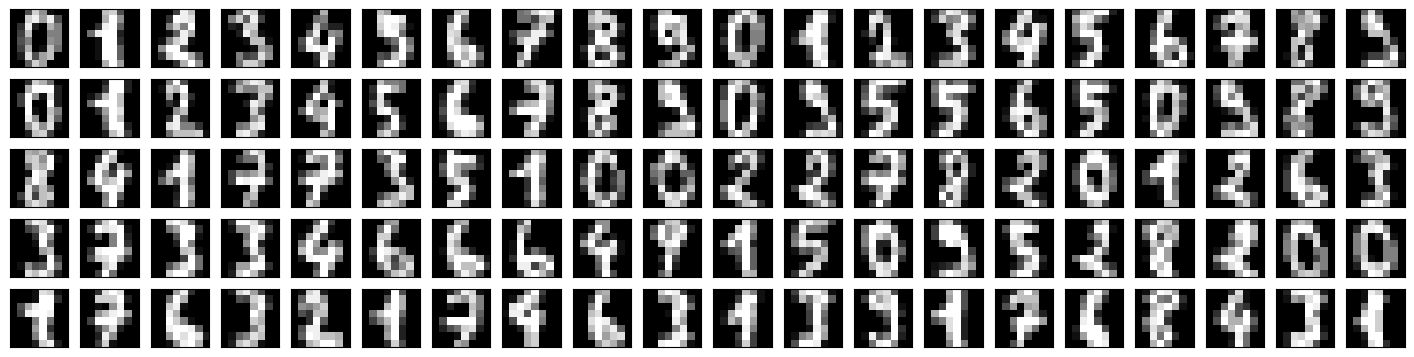

In [28]:
from sklearn.datasets import load_digits
digits = load_digits()
X=digits.data/16
y=digits.target
plt.rcParams["figure.figsize"] = (18,18)
plt.gray()
for i in range(100):
    plt.subplot(20, 20, i + 1)
    plt.imshow(digits.images[i], cmap=plt.cm.gray, vmax=16, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.show()

# Plot Function

In [29]:


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

def categorical_scatter_2d(X2D, class_idxs, ms=3, ax=None, alpha=0.1,
                           legend=True, figsize=None, show=False,
                           savename=None):
    ## Plot a 2D matrix with corresponding class labels: each class diff colour
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    #ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    classes = list(np.unique(class_idxs))
    markers = ['o', 's', 'o', 's', 'o', 's', 'o', 's', 'o', 's']
    colors = plt.cm.tab10(np.linspace(0, 1, len(classes)))

    # Plot the image to plot
    # Hint: Create the loop of "classes" and use ax.plot()
    for i, class_idx in enumerate(classes):
        class_X = X2D[class_idxs == class_idx]
        ax.plot(class_X[:, 0], class_X[:, 1], marker=markers[i], linestyle='', color=colors[i], label=str(class_idx), alpha=alpha, ms=ms, markeredgecolor='black', markeredgewidth=0.5)

    if legend:
        ax.legend()

    if savename is not None:
        plt.tight_layout()
        plt.savefig(savename)

    if show:
        plt.show()

    return ax

# ISOMAP

# Ball Tree

In [30]:
def BuildSubtree(root,points,index,leaf_size,depth):
    if(depth==0):
        return
    centroid=np.mean(points[index,:],axis=0)
    root.centroid=centroid
    root.radius=np.max(np.sum((points[index,:]-centroid)**2,axis=1))**0.5
    farthest_point_1=np.argmax(np.sum((points[index,:]-centroid)**2,axis=1))
    real_index_1=index[farthest_point_1]
    distance_array_1=np.sum((points[index,:]-points[real_index_1,:])**2,axis=1)
    farthest_point_2=np.argmax(np.sum((points[index,:]-points[real_index_1,:])**2,axis=1))
    real_index_2=index[farthest_point_2]
    distance_array_2=np.sum((points[index,:]-points[real_index_2,:])**2,axis=1)
    BOOL=(distance_array_1<=distance_array_2)
    child1_index,child2_index=index[BOOL],index[~BOOL]
    root.index1,root.index2=real_index_1,real_index_2
    if(len(child1_index)<=leaf_size and len(child2_index)<=leaf_size):
        if(depth==1):
            print("tree is not complete")
        root.child1="end"
        root.child2="end"
    elif(len(child1_index)<=leaf_size):
        root.child1="end"
        root.child2=Tree()
        BuildSubtree(root.child2,points,child2_index,leaf_size,depth-1)
    elif(len(child2_index)<=leaf_size):
        root.child2="end"
        root.child1=Tree()
        BuildSubtree(root.child1,points,child1_index,leaf_size,depth-1)
    else:
        root.child1=Tree()
        BuildSubtree(root.child1,points,child1_index,leaf_size,depth-1)
        root.child2=Tree()
        BuildSubtree(root.child2,points,child2_index,leaf_size,depth-1)
    return

# K-NN Algorithm

In [31]:
def check(X,p,k,Q,index):
    if(np.sum((p-X[index,:])**2)<np.sum((p-X[Q[0],:])**2)):
        Q.append(index)
        Q=np.array(Q)
        Q=list(Q[np.argsort(-1*np.sum((p-X[Q,:])**2,axis=1))])
        if(len(Q)>k):
            del Q[0]
    return Q

def kNN_search(X,p,k,Q,root):
    if(np.sqrt(np.sum((p-root.centroid)**2))-root.radius>=np.sqrt(np.sum((p-X[Q[0],:])**2))):
        return Q
    elif(root.child1=="end" and root.child2=="end"):
        Q=check(X,p,k,Q,root.index1)
        Q=check(X,p,k,Q,root.index2)
    elif(root.child1=="end"):
        Q=check(X,p,k,Q,root.index1)
        Q=kNN_search(X,p,k,Q,root.child2)
    elif(root.child2=="end"):
        Q=check(X,p,k,Q,root.index2)
        Q=kNN_search(X,p,k,Q,root.child1)
    else:
        Q=kNN_search(X,p,k,Q,root.child1)
        Q=kNN_search(X,p,k,Q,root.child2)
    return Q

# Dijkstra's algorithm with Fibonacci stacks
The code is from Sci-Kit Learn Open Source Project: Shortest Path Algorithms

In [32]:
%%cython
import numpy as np
cimport numpy as np
from scipy.sparse import csr_matrix, isspmatrix, isspmatrix_csr
cimport cython
from libc.stdlib cimport malloc, free
np.import_array()
DTYPE = np.float64
ctypedef np.float64_t DTYPE_t
ITYPE = np.int32
ctypedef np.int32_t ITYPE_t
cdef struct FibonacciNode:
    unsigned int index
    unsigned int rank
    unsigned int state
    DTYPE_t val
    FibonacciNode* parent
    FibonacciNode* left_sibling
    FibonacciNode* right_sibling
    FibonacciNode* children
ctypedef FibonacciNode* pFibonacciNode
cdef struct FibonacciHeap:
    FibonacciNode* min_node
    pFibonacciNode[100] roots_by_rank
cdef void insert_node(FibonacciHeap* heap,FibonacciNode* node):
    if heap.min_node:
        add_sibling(heap.min_node, node)
        if node.val < heap.min_node.val:
            heap.min_node = node
    else:
        heap.min_node = node
cdef void decrease_val(FibonacciHeap* heap,FibonacciNode* node,DTYPE_t newval):
    node.val = newval
    if node.parent and (node.parent.val >= newval):
        remove(node)
        insert_node(heap, node)
    elif heap.min_node.val > node.val:
        heap.min_node = node
cdef void link(FibonacciHeap* heap, FibonacciNode* node):
    cdef FibonacciNode *linknode
    cdef FibonacciNode *parent
    cdef FibonacciNode *child
    if heap.roots_by_rank[node.rank] == NULL:
        heap.roots_by_rank[node.rank] = node
    else:
        linknode = heap.roots_by_rank[node.rank]
        heap.roots_by_rank[node.rank] = NULL
        if node.val < linknode.val or node == heap.min_node:
            remove(linknode)
            add_child(node, linknode)
            link(heap, node)
        else:
            remove(node)
            add_child(linknode, node)
            link(heap, linknode)
cdef FibonacciNode* remove_min(FibonacciHeap* heap):
    cdef FibonacciNode *temp
    cdef FibonacciNode *temp_right
    cdef FibonacciNode *out
    cdef unsigned int i
    if heap.min_node.children:
        temp = leftmost_sibling(heap.min_node.children)
        temp_right = NULL
        while temp:
            temp_right = temp.right_sibling
            remove(temp)
            add_sibling(heap.min_node, temp)
            temp = temp_right
        heap.min_node.children = NULL
    temp = leftmost_sibling(heap.min_node)
    if temp == heap.min_node:
        if heap.min_node.right_sibling:
            temp = heap.min_node.right_sibling
        else:
            out = heap.min_node
            heap.min_node = NULL
            return out
    out = heap.min_node
    remove(heap.min_node)
    heap.min_node = temp
    for i from 0 <= i < 100:
        heap.roots_by_rank[i] = NULL
    while temp:
        if temp.val < heap.min_node.val:
            heap.min_node = temp
        temp_right = temp.right_sibling
        link(heap, temp)
        temp = temp_right
    return out
cdef void initialize_node(FibonacciNode* node,unsigned int index,DTYPE_t val=0):
    node.index = index
    node.val = val
    node.rank = 0
    node.state = 0
    node.parent = NULL
    node.left_sibling = NULL
    node.right_sibling = NULL
    node.children = NULL
cdef FibonacciNode* rightmost_sibling(FibonacciNode* node):
    cdef FibonacciNode* temp = node
    while(temp.right_sibling):
        temp = temp.right_sibling
    return temp
cdef FibonacciNode* leftmost_sibling(FibonacciNode* node):
    cdef FibonacciNode* temp = node
    while(temp.left_sibling):
        temp = temp.left_sibling
    return temp
cdef void add_child(FibonacciNode* node, FibonacciNode* new_child):
    new_child.parent = node
    if node.children:
        add_sibling(node.children, new_child)
    else:
        node.children = new_child
        new_child.right_sibling = NULL
        new_child.left_sibling = NULL
        node.rank = 1
cdef void add_sibling(FibonacciNode* node, FibonacciNode* new_sibling):
    cdef FibonacciNode* temp = rightmost_sibling(node)
    temp.right_sibling = new_sibling
    new_sibling.left_sibling = temp
    new_sibling.right_sibling = NULL
    new_sibling.parent = node.parent
    if new_sibling.parent:
        new_sibling.parent.rank += 1
cdef void remove(FibonacciNode* node):
    if node.parent:
        node.parent.rank -= 1
        if node.left_sibling:
            node.parent.children = node.left_sibling
        elif node.right_sibling:
            node.parent.children = node.right_sibling
        else:
            node.parent.children = NULL
    if node.left_sibling:
        node.left_sibling.right_sibling = node.right_sibling
    if node.right_sibling:
        node.right_sibling.left_sibling = node.left_sibling
    node.left_sibling = NULL
    node.right_sibling = NULL
    node.parent = NULL
cdef void dijkstra_one_row(unsigned int i_node,
                    np.ndarray[ITYPE_t, ndim=1, mode='c'] neighbors1,
                    np.ndarray[DTYPE_t, ndim=1, mode='c'] distances1,
                    np.ndarray[ITYPE_t, ndim=1, mode='c'] indptr1,
                    np.ndarray[ITYPE_t, ndim=1, mode='c'] neighbors2,
                    np.ndarray[DTYPE_t, ndim=1, mode='c'] distances2,
                    np.ndarray[ITYPE_t, ndim=1, mode='c'] indptr2,
                    np.ndarray[DTYPE_t, ndim=2, mode='c'] graph,
                    FibonacciHeap* heap,
                    FibonacciNode* nodes):
    cdef unsigned int N = graph.shape[0]
    cdef unsigned int i_N
    cdef ITYPE_t i
    cdef FibonacciNode *v
    cdef FibonacciNode *current_neighbor
    cdef DTYPE_t dist
    for i_N in range(0, N):
        nodes[i_N].state = 0
        nodes[i_N].val = 0
    insert_node(heap, &nodes[i_node])
    while heap.min_node:
        v = remove_min(heap)
        v.state = 2
        for i from indptr1[v.index] <= i < indptr1[v.index + 1]:
            current_neighbor = &nodes[neighbors1[i]]
            if current_neighbor.state != 2:
                dist = distances1[i]
                if current_neighbor.state == 0:
                    current_neighbor.state = 1
                    current_neighbor.val = v.val + dist
                    insert_node(heap, current_neighbor)
                elif current_neighbor.val > v.val + dist:
                    decrease_val(heap, current_neighbor,v.val + dist)
        for i from indptr2[v.index] <= i < indptr2[v.index + 1]:
            current_neighbor = &nodes[neighbors2[i]]
            if current_neighbor.state != 2:
                dist = distances2[i]
                if current_neighbor.state == 0:
                    current_neighbor.state = 1
                    current_neighbor.val = v.val + dist
                    insert_node(heap, current_neighbor)
                elif current_neighbor.val > v.val + dist:
                    decrease_val(heap, current_neighbor,v.val + dist)
        graph[i_node, v.index] = v.val
cdef np.ndarray dijkstra(dist_matrix,np.ndarray[DTYPE_t, ndim=2] graph):
    cdef unsigned int N = graph.shape[0]
    cdef unsigned int i
    cdef FibonacciHeap heap
    cdef FibonacciNode* nodes = <FibonacciNode*> malloc(N*sizeof(FibonacciNode))
    cdef np.ndarray distances, neighbors, indptr
    cdef np.ndarray distances2, neighbors2, indptr2
    if not isspmatrix_csr(dist_matrix):
        dist_matrix = csr_matrix(dist_matrix)
    distances = np.asarray(dist_matrix.data, dtype=DTYPE, order='C')
    neighbors = np.asarray(dist_matrix.indices, dtype=ITYPE, order='C')
    indptr = np.asarray(dist_matrix.indptr, dtype=ITYPE, order='C')
    for i from 0 <= i < N:
        initialize_node(&nodes[i], i)
    heap.min_node = NULL
    dist_matrix_T = dist_matrix.T.tocsr()
    distances2 = np.asarray(dist_matrix_T.data,dtype=DTYPE, order='C')
    neighbors2 = np.asarray(dist_matrix_T.indices,dtype=ITYPE, order='C')
    indptr2 = np.asarray(dist_matrix_T.indptr,dtype=ITYPE, order='C')
    for i from 0 <= i < N:
        dijkstra_one_row(i, neighbors, distances, indptr,
                             neighbors2, distances2, indptr2,
                             graph, &heap, nodes)
    free(nodes)
    return graph
def graph_shortest_path(dist_matrix):
    if not isspmatrix_csr(dist_matrix):
        dist_matrix = csr_matrix(dist_matrix)
    N = dist_matrix.shape[0]
    Nk = len(dist_matrix.data)
    graph = np.zeros((N, N), dtype=DTYPE, order='C')
    dijkstra(dist_matrix, graph)
    return graph

# Building Tree

In [33]:
class Tree:
    def __init__(self):
        self.child1=None
        self.child2=None
        self.radius=None
        self.centroid=None
        self.index1=None
        self.index2=None

# Nearest Neighbor Search

In [34]:
# initialize data structure
root=Tree()
N,M=X.shape
Index=np.array(range(0,N))
BuildSubtree(root,X,Index,1,30)
Mat=np.zeros((N,N))

# Set num of neighbor (You can change)
k = 5

# k-NN search
for i in tqdm(range(0,N)):
    Q=[]
    while(len(Q) != k):
        Q=list(np.random.randint(N, size=1))
        Q=kNN_search(X,X[i,:],k,Q,root)
    Mat[i,Q]=np.sqrt(np.sum((X[Q,:]-X[i,:])**2, axis=1))
print(Mat)

  0%|          | 0/1797 [00:00<?, ?it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Compute Geodesic distance Matrix

In [35]:
D = graph_shortest_path(Mat)
print(D)

[[ 0.         16.26895081 21.61670988 ... 16.40061999 20.16456508
  13.31780818]
 [16.26895081  0.          6.60640031 ...  4.72122693 13.83241077
   5.83087649]
 [21.61670988  6.60640031  0.         ...  7.92890669 14.54806513
   8.29890171]
 ...
 [16.40061999  4.72122693  7.92890669 ...  0.          9.11118384
   3.08281182]
 [20.16456508 13.83241077 14.54806513 ...  9.11118384  0.
  11.67920617]
 [13.31780818  5.83087649  8.29890171 ...  3.08281182 11.67920617
   0.        ]]


# Dimensional Reduction

In this section, you need to implement the Dimensional Reduction step of ISOMAP by your own. Below are the formulas for this step.
1. Compute the double-centering matrix $B$, where $D^{2}$ is the power of the Geodesic distance Matrix computed in the previous section.

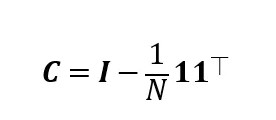

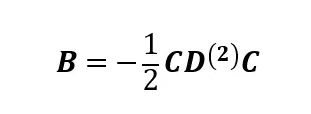

2. Do eigen decomposition on matrix $B$.

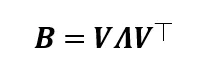

3. Use first $m$ eigenvalues and corresponding eigenvectors to compute the dimentional reduction matrix $\hat X$.

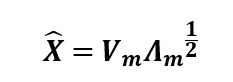

In [36]:
def dimensional_reduction(N,D):
  C = np.eye(N) - np.ones((N, N)) / N
  B = -0.5 * np.dot(np.dot(C, D**2), C)
  A, V = np.linalg.eigh(B)
  idx = np.argsort(A)[::-1]
  X_hat = np.dot(V[:,idx[:2]],np.diag(A[idx[:2]]))

  X_hat *= -1

  return X_hat

X_hat = dimensional_reduction(N,D)

# Plot ISOMAP

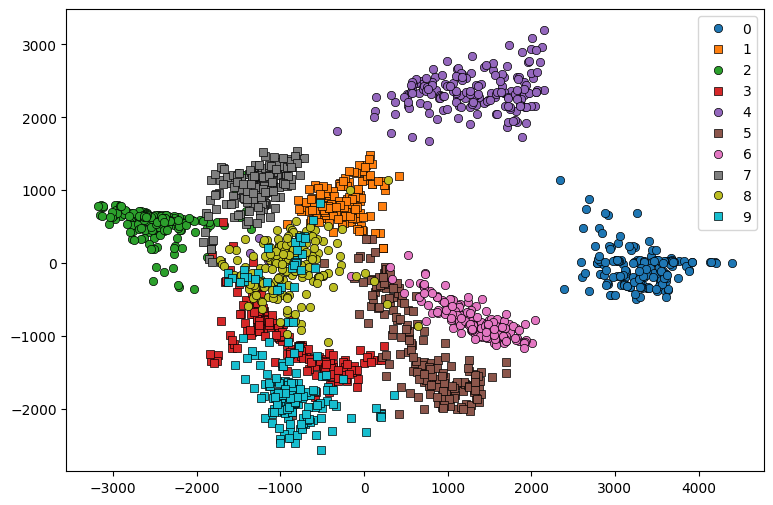

<Axes: >

In [37]:
categorical_scatter_2d(X_hat, y, alpha=1.0, ms=6, show=True, figsize=(9, 6))

# t-SNE

# Euclidean distances matrix

In [71]:
def neg_squared_euc_dists(X):
    """Compute matrix containing negative squared euclidean
    distance for all pairs of points in input matrix X

    # Arguments:
        X: matrix of size NxD
    # Returns:
        NxN matrix D, with entry D_ij = negative squared
        euclidean distance between rows X_i and X_j
    """

    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    return -D

In [90]:
def softmax(X, diag_zero=True):
    """Take softmax of each row of matrix X."""
    e_x = np.exp(X - np.max(X, axis=1).reshape([-1, 1]))
    if diag_zero:
        np.fill_diagonal(e_x, 0)
    e_x = e_x + 1e-8

    return e_x / e_x.sum(axis=1).reshape([-1, 1])

In [73]:
def calc_prob_matrix(distances, sigmas=None):
    """Convert a distances matrix to a matrix of probabilities."""
    if sigmas is not None:
        two_sig_sq = 2. * np.square(sigmas.reshape((-1, 1)))
        return softmax(distances / two_sig_sq)
    else:
        return softmax(distances)

# perplexity

In [74]:
def binary_search(eval_fn, target, tol=1e-10, max_iter=10000,
                  lower=1e-20, upper=1000.):
    """Perform a binary search over input values to eval_fn.

    # Arguments
        eval_fn: Function that we are optimising over.
        target: Target value we want the function to output.
        tol: Float, once our guess is this close to target, stop.
        max_iter: Integer, maximum num. iterations to search for.
        lower: Float, lower bound of search range.
        upper: Float, upper bound of search range.
    # Returns:
        Float, best input value to function found during search.
    """
    for i in range(max_iter):
        guess = (lower + upper) / 2.
        val = eval_fn(guess)
        if val > target:
            upper = guess
        else:
            lower = guess
        if np.abs(val - target) <= tol:
            break
    return guess

In [75]:
def calc_perplexity(prob_matrix):
    """Calculate the perplexity of each row
    of a matrix of probabilities."""
    entropy = -np.sum(prob_matrix * np.log2(prob_matrix), 1)
    perplexity = 2 ** entropy
    return perplexity


def perplexity(distances, sigmas):
    """Wrapper function for quick calculation of
    perplexity over a distance matrix."""
    return calc_perplexity(calc_prob_matrix(distances, sigmas))


def find_optimal_sigmas(distances, target_perplexity):
    """For each row of distances matrix, find sigma that results
    in target perplexity for that role."""
    sigmas = []
    # For each row of the matrix (each point in our dataset)
    for i in range(distances.shape[0]):
        # Make fn that returns perplexity of this row given sigma
        eval_fn = lambda sigma: \
            perplexity(distances[i:i+1, :], np.array(sigma))
        # Binary search over sigmas to achieve target perplexity
        correct_sigma = binary_search(eval_fn, target_perplexity)
        # Append the resulting sigma to our output array
        sigmas.append(correct_sigma)
    return np.array(sigmas)

# $q$ used in Symmetric SNE

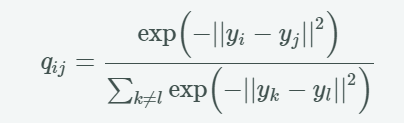

In [76]:
def q_joint(Y):
    """Given low-dimensional representations Y, compute
    matrix of joint probabilities with entries q_ij."""
    # Get the distances from every point to every other
    distances = neg_squared_euc_dists(Y)
    # Take the elementwise exponent
    exp_distances = np.exp(distances)
    # Fill diagonal with zeroes so q_ii = 0
    np.fill_diagonal(exp_distances, 0.)
    # Divide by the sum of the entire exponentiated matrix
    return exp_distances / np.sum(exp_distances), None

# $p$

In [77]:
def p_conditional_to_joint(P):
    """Given conditional probabilities matrix P, return
    approximation of joint distribution probabilities."""
    return (P + P.T) / (2. * P.shape[0])

def p_joint(X, target_perplexity):
    """Given a data matrix X, gives joint probabilities matrix.

    # Arguments
        X: Input data matrix.
    # Returns:
        P: Matrix with entries p_ij = joint probabilities.
    """
    # Get the negative euclidian distances matrix for our data
    distances = neg_squared_euc_dists(X)
    # Find optimal sigma for each row of this distances matrix
    sigmas = find_optimal_sigmas(distances, target_perplexity)
    # Calculate the probabilities based on these optimal sigmas
    p_conditional = calc_prob_matrix(distances, sigmas)
    # Go from conditional to joint probabilities matrix
    P = p_conditional_to_joint(p_conditional)
    return P

# Symmetric SNE

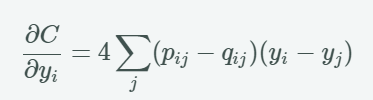

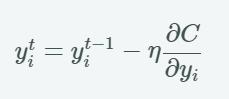

In [78]:
def symmetric_sne_grad(P, Q, Y, _):
    """Estimate the gradient of the cost with respect to Y"""
    pq_diff = P - Q  # NxN matrix
    pq_expanded = np.expand_dims(pq_diff, 2)  #NxNx1
    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)  #NxNx2
    grad = 4. * (pq_expanded * y_diffs).sum(1)  #Nx2
    return grad

# t-SNE

In this section, you need to implement t-SNE by your own. You can check the code in Symmetric SNE, then modify then to do the t-SNE.
1. $q$ in t-SNE.

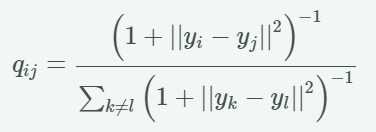

2. gradient dervied in the t-SNE.

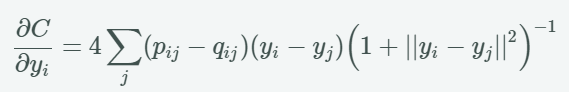

In [80]:
def q_tsne(Y):
    """t-SNE: Given low-dimensional representations Y, compute
    matrix of joint probabilities with entries q_ij."""

    distances = neg_squared_euc_dists(Y)
    inv_distances = np.power(1. - distances, -1)
    np.fill_diagonal(inv_distances, 0.)

    return inv_distances / np.sum(inv_distances), inv_distances

def tsne_grad(P, Q, Y, inv_distances):
    """Estimate the gradient of t-SNE cost with respect to Y."""
    '''Write your code here'''
    pq_diff = P - Q
    pq_expanded = np.expand_dims(pq_diff, 2)
    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)

    # Expand our inv_distances matrix so can multiply by y_diffs
    distances_expanded = np.expand_dims(inv_distances, 2)

    # Multiply this by inverse distances matrix
    y_diffs_wt = y_diffs * distances_expanded

    # Multiply then sum over j's
    grad = 4. * (pq_expanded * y_diffs_wt).sum(1)

    return grad

# Estimate SNE

In [ ]:
def estimate_sne(X, y, P, rng, num_iters, q_fn, grad_fn, learning_rate,
                 momentum, plot):
    """Estimates a SNE model.

    # Arguments
        X: Input data matrix.
        y: Class labels for that matrix.
        P: Matrix of joint probabilities.
        rng: np.random.RandomState().
        num_iters: Iterations to train for.
        q_fn: Function that takes Y and gives Q prob matrix.
        plot: How many times to plot during training.
    # Returns:
        Y: Matrix, low-dimensional representation of X.
    """

    # Initialise our 2D representation
    Y = rng.normal(0., 0.0001, [X.shape[0], 2])

    # Initialise past values (used for momentum)
    if momentum:
        Y_m2 = Y.copy()
        Y_m1 = Y.copy()

    # Start gradient descent loop
    for i in range(num_iters):

        # Get Q and distances (distances only used for t-SNE)
        Q, distances = q_fn(Y)
        # Estimate gradients with respect to Y
        grads = grad_fn(P, Q, Y, distances)

        # Update Y
        Y -= learning_rate * grads
        if momentum:  # Add momentum
            Y += momentum * (Y_m1 - Y_m2)
            # Update previous Y's for momentum
            Y_m2 = Y_m1.copy()
            Y_m1 = Y.copy()

        # Plot sometimes
        if plot and i % (num_iters / plot) == 0:
            categorical_scatter_2d(Y, y, alpha=1.0, ms=6,
                        show=True, figsize=(9, 6))

    return Y

# Plot SNE

10.0


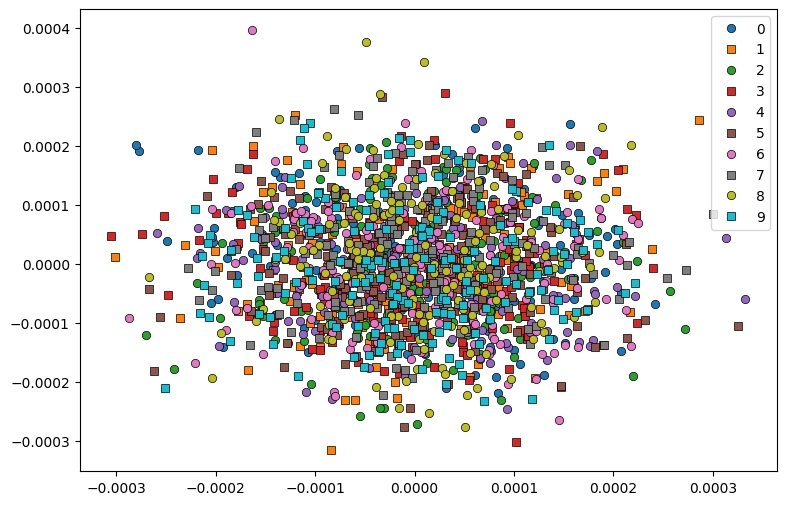

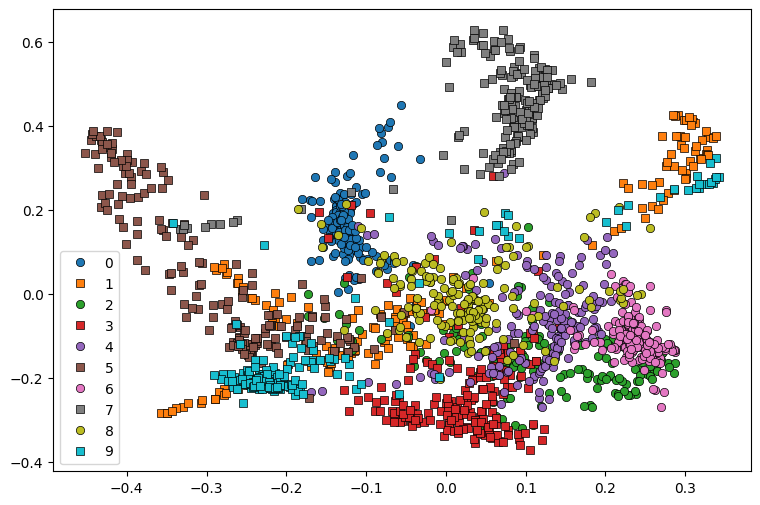

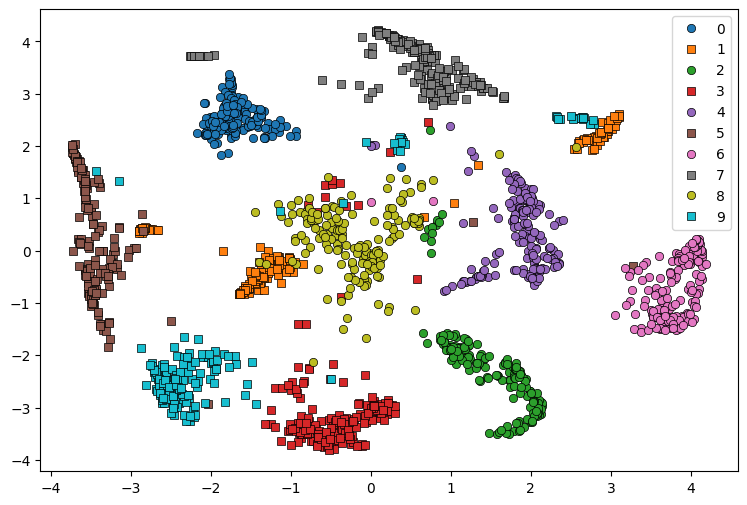

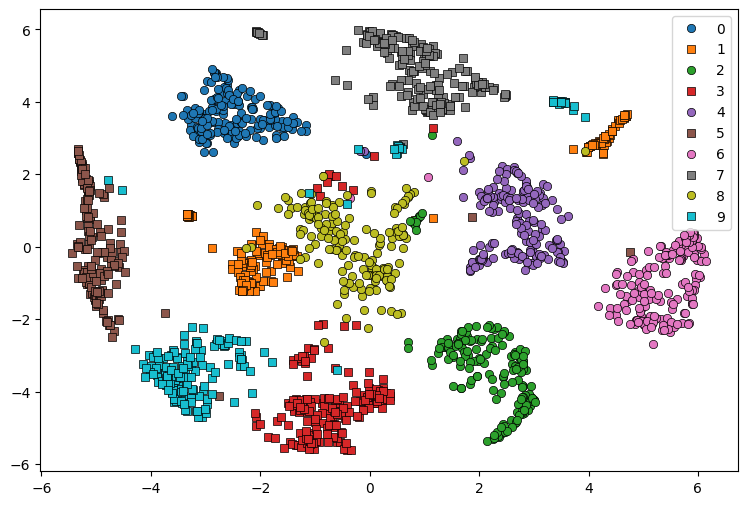

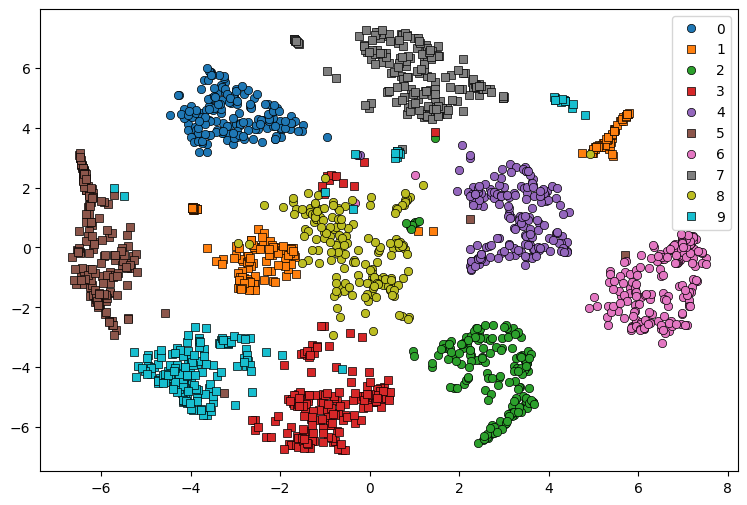

In [92]:
# Set global parameters (You can change)
PERPLEXITY = 20
SEED = 1            # Random seed
MOMENTUM = 0.9
LEARNING_RATE = 10.
NUM_ITERS = 500     # Num iterations to train for
TSNE = True         # If False, Symmetric SNE
NUM_PLOTS = 5       # Num. times to plot in training


# numpy RandomState for reproducibility
rng = np.random.RandomState(SEED)

# Obtain matrix of joint probabilities p_ij
P = p_joint(X, PERPLEXITY)

# Fit SNE or t-SNE
Y = estimate_sne(X, y, P, rng,
          num_iters=NUM_ITERS,
          q_fn=q_tsne if TSNE else q_joint,
          grad_fn=tsne_grad if TSNE else symmetric_sne_grad,
          learning_rate=LEARNING_RATE,
          momentum=MOMENTUM,
          plot=NUM_PLOTS)